# Creation of synthetic data for a stroke thrombolysis pathway data set using a Generative Advesarial Network (GAN). Tested using a logistic regression model.

## Aim

To test a Generative Advesarial Network (GAN) for synthesising data that can be used to train a logistic regression machine learning model.

Generative Advesarial Networks (GANs) are composed of two competing networks:

* A *descriminator* network: This produces an output (0-1) that determines whether a particular example is fake (output=0) or real (output=1).
* A *generator* network: This network produces synthetic (fake) examples

The networks are trained together. With each iteration:

* The *descriminator* network is trained on a set of labelled examples (real examples have a label of 1, those produced by the gernator network have a label of 0).
* The *generator* network is trained by passing generated examples to the *descriminator* network. The loss function is the difference between the *descriminator* output and a value of 1 (for an example which is classified as 100% probability of being real by the *descriminator network*). The *descriminator* output is passed to the *generator network* complete with *gradients*, so that the *generator network* can be trained with gradients back from the *descriminator* output (see figure below).

Improvement in the *descriminator* network provides a better feedback to the *generator network*, producing better examples. 

1 Goodfellow I, Pouget-Abadie J, Mirza M, et al. Generative Adversarial Nets. In: Ghahramani Z, Welling M, Cortes C, et al., eds. Advances in Neural Information Processing Systems 27. Curran Associates, Inc. 2014. 2672–2680. http://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf


![](../images/generative-adversarial-network.png)

## Data

Raw data is avilable at: 

https://raw.githubusercontent.com/MichaelAllen1966/1807_stroke_pathway/master/machine_learning/data/data_for_ml_clin_only.csv

## Basic methods description

* Create synthetic data by use of a Generative Adversarial Network (GAN)
* Train logistic regression model on synthetic data and test against held-back raw data

### Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Turn warnings off for notebook publication
import warnings
warnings.filterwarnings("ignore")

### Chech whether GPU (CUDA) present

If GPU is present the code will run on GPU, otherwsie it will run on CPU.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
print('Device:', device)

Device: cuda


## Function to turn an array of float values into one-hot

In [3]:
def make_one_hot(x):
    """
    Takes a list/array/series and returns 1 for highest value and 0 for all 
    others
    
    """
    # Get argmax
    highest = np.argmax(x)
    # Set all values to zero
    x *= 0.0
    # Set argmax to one
    x[highest] = 1.0
    
    return x

### Import Data

Data is imported from local wisconsin.csv file (held in same directory as this notebook). Data can also be accessed here: https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

In [4]:
def load_data():
    """"
    Load Stroke Pathway data set
    
    Inputs
    ------
    None
    
    Returns
    -------
    X: NumPy array of X
    y: Numpy array of y
    col_names: column names for X
    """    
    
    # Load data 
    data = pd.read_csv('./stroke_pathway.csv')
    
    # Shuffle data
    data = data.sample(frac=1)   

    # Change 'Thrombolysis given' column to 'thrombolysis', and put last
    data['label'] = data['Thrombolysis given']
    data.drop('Thrombolysis given', axis=1, inplace=True)

    # Split data in X and y
    X = data.drop(['label'], axis=1)
    y = data['label']
    
    # Get col names and convert to NumPy arrays
    X_col_names = list(X)
    X = X.values
    y = y.values
    
    return data, X, y, X_col_names 

### Data processing

Function for splitting X and y into training and test sets.

In [5]:
def split_into_train_test(X, y, test_proportion=0.25):    
    """"
    Randomly split X and y numpy arrays into training and test data sets
    
    Inputs
    ------
    X and y NumPy arrays
    
    Returns
    -------
    X_test, X_train, y_test, y_train Numpy arrays
    """
    
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, shuffle=True, test_size=test_proportion)
        
    return X_train, X_test, y_train, y_test  

Function to standardise data (based on mean and dtandard deviation of training data).

In [6]:
def standardise_data(X_train, X_test):
    """"
    Standardise training and tets data sets according to mean and standard
    deviation of test set
    
    Inputs
    ------
    X_train, X_test NumPy arrays
    
    Returns
    -------
    X_train_std, X_test_std
    """
    
    mu = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    
    X_train_std = (X_train - mu) / std
    X_test_std = (X_test - mu) /std
    
    return X_train_std, X_test_std
    

### Calculate accuracy measures

Function to calculate a range of accuracy scores.

In [7]:
def calculate_diagnostic_performance(actual, predicted):
    """     
    Inputs
    ------
    actual, predted numpy arrays (1 = +ve, 0 = -ve)
    
    Returns
    -------
    A dictionary of results:
    
    1)  accuracy: proportion of test results that are correct    
    2)  sensitivity: proportion of true +ve identified
    3)  specificity: proportion of true -ve identified
    4)  positive likelihood: increased probability of true +ve if test +ve
    5)  negative likelihood: reduced probability of true +ve if test -ve
    6)  diagnostic odds ratio: positive likelihood / negative likelihood
    7)  true positive rate: same as sensitivity
    8)  true negative rate: same as specificity
    9)  false positive rate: proportion of false +ves in true -ve patients
    10) false negative rate:  proportion of false -ves in true +ve patients
    11) positive predictive value: chance of true +ve if test +ve
    12) negative predictive value: chance of true -ve if test -ve
    13) actual positive rate: proportion of actual values that are +ve
    14) predicted positive rate: proportion of predicted vales that are +ve
    15) recall: same as sensitivity
    16) precision: the proportion of predicted +ve that are true +ve
    17) f1: 2 * ((precision * recall) / (precision + recall))

    *false positive rate is the percentage of healthy individuals who 
    incorrectly receive a positive test result
    * alse neagtive rate is the percentage of diseased individuals who 
    incorrectly receive a negative test result
    
    """
    
    # Calculate results 
    actual_positives = actual == 1
    actual_negatives = actual == 0
    test_positives = predicted == 1
    test_negatives = predicted == 0
    
    test_correct = actual == predicted
    accuracy = test_correct.mean()
    
    true_positives = actual_positives & test_positives
    false_positives = test_positives & actual_negatives
    true_negatives = actual_negatives & test_negatives
    false_negatives = test_negatives & actual_positives
    
    sensitivity = true_positives.sum() / actual_positives.sum()
    specificity = true_negatives.sum() / actual_negatives.sum()

    true_positive_rate = sensitivity
    true_negative_rate = specificity
    false_positive_rate = 1 - specificity
    false_negative_rate = 1 - sensitivity
    
    positive_likelihood = true_positive_rate / false_positive_rate
    negative_likelihood = false_positive_rate / true_negative_rate
    diagnostic_odds_ratio = positive_likelihood / negative_likelihood
    
    positive_predictive_value = true_positives.sum() / test_positives.sum()
    negative_predicitive_value = true_negatives.sum() / test_negatives.sum()
    
    actual_positive_rate = actual.mean()
    predicted_positive_rate = predicted.mean()
    
    recall = sensitivity
    precision = true_positives.sum() / actual_positives.sum()
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    # Add results to dictionary
    results = dict()
    results['accuracy'] = accuracy
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['diagnostic_odds_ratio'] = diagnostic_odds_ratio
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predicitive_value'] = negative_predicitive_value
    results['actual_positive_rate'] = actual_positive_rate
    results['predicted_positive_rate'] = predicted_positive_rate
    results['recall'] = recall
    results['precision'] = precision
    results['f1'] = f1
   
    return results

### Logistic Regression Model

Function to fit and test a logistic regression model (when synthetic data is used the model is fitted on synthetic data but tested on real data).

In [8]:
def fit_and_test_logistic_regression_model(X_train, X_test, y_train, y_test):    
    """"
    Fit and test logistic regression model. 
    Return a dictionary of accuracy measures.
    Calls on `calculate_diagnostic_performance` to calculate results
    
    Inputs
    ------
    X_train, X_test NumPy arrays
    
    Returns
    -------
    A dictionary of accuracy results.
    """
    
    # Fit logistic regression model 
    lr = LogisticRegression(C=0.1)
    lr.fit(X_train,y_train)

    # Predict tets set labels
    y_pred = lr.predict(X_test_std)
    
    # Get accuracy results
    accuracy_results = calculate_diagnostic_performance(y_test, y_pred)
    
    return accuracy_results

### Synthetic Data Method - Generative Adverasrial Network

#### Define the standalone discriminator model

The disctriminator is passed a vector of features (`X`). For training, the discriminator is passed a value of `y` that labels whether the sample is from synthetic data (`y=0`) of from real data (`y=1`). Note that the y label here does not correspond to labels in the original data set, but simply refere to whether the data is real or synthetic.

In [9]:
class Discriminator(torch.nn.Module):

    def __init__(self, features):
        """
        Constructor method for discriminator network.
        Inherits from parent torch.nn.Module class.
        """
        
        # Inherit from parent class
        super(Discriminator, self).__init__()
        
        # Define layers
        self.fc1 = torch.nn.Linear(features, features * 5)
        self.fc2 = torch.nn.Linear(features * 5, features * 5)
        self.fc3 = torch.nn.Linear(features * 5, 1)

    def forward(self, x):
        """Foward pass through network."""
        
        x = self.fc1(x) # Fully connected layer
        x = F.dropout(x, p=0.2) # Apply dropout
        x = F.relu(x) # ReLU activation
        x = self.fc2(x) # Fully connected layer
        x = F.dropout(x, p=0.2) # Apply dropout
        x = F.relu(x) # ReLU activation
        x = self.fc3(x) # Fully connected layer
        x = torch.sigmoid(x) # Sigmoid output (0-1)

        return x

#### Define the standalone generator model

The generator model converts a vector of *latent* feature values into an output array of features corresponding to clinical features. Values of latent feature array will be generated as simple randon munbers in the range 0-1.

In [10]:
class Generator(torch.nn.Module):

    def __init__(self, input_dim, features):
        """
        Constructor method for generator network.
        Inherits from parent torch.nn.Module class.
        """
        
        # Inherit from parent class
        super(Generator, self).__init__()
        
        # Define layers
        self.fc1 = torch.nn.Linear(input_dim, features * 5)
        self.fc2 = torch.nn.Linear(features * 5, features * 5)
        self.fc3 = torch.nn.Linear(features * 5, features)

    def forward(self, x):
        """Foward pass through network."""
        
        x = self.fc1(x) # Fully connected layer
        x = F.dropout(x, p=0.2) # Apply dropout
        x = F.relu(x) # ReLU activation
        x = self.fc2(x) # Fully connected layer
        x = F.dropout(x, p=0.2) # Apply dropout
        x = F.relu(x) # ReLU activation
        x = self.fc3(x) # Fully connected layer 

        return x

#### Generate a batch of real samples

Real samples come from sampling from the orginal data set.

The `y` value is set to `1` to identify these samples as real.

In [11]:
def generate_real_samples(X, n):
    """Sample data from real data set"""
    
    # Combine X and y, shuffle, split X and y and return sample
    shuffle_index = np.random.permutation(np.arange(X.shape[0]))
    shuffled = X[shuffle_index]
    X_sample = shuffled[0:n]
    y_sample = np.ones((n, 1))
    
    return X_sample, y_sample

#### Generate a batch of synthetic samples

Synthetic samples are produced by using the generator model as a stand-alone model.
Latent points are generated by a random number generator (see below)

The `y` value is set to `0` to identify these samples as synthetic.

In [12]:
def generate_latent_points(latent_dim, n):
    """
    Creates a NumPy array of random points for input into generator.
    Size is number of replications needed * number of latent input features in
    generator network.    
    """
    
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    
    return x_input

In [13]:
def generate_synthetic_samples(generator, latent_dim, n):
    """
    Get synthetic data, by passing an array of random latent
    points (input for generator network) to generator.
    """
    
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs (use eval mode of generator)
    generator.eval()
    X = generator(torch.Tensor(x_input).to(device))
    # Copy to CPU before converting to NumPy
    X = X.to('cpu')
    X = X.detach().numpy()
    # create class labels
    y = np.zeros((n, 1))
    
    return X, y

#### Train the generator and discriminator

In [14]:
def train(X, y, g_model, d_model, latent_dim, n_epochs, n_batch, learning_rate):
    """
    Train discriminator and generator. 
    Training proceedsd through a number of epochs.
    In each epoch the discriminaror is first trained with a batch of ral and
    fake (synthetic samples), to learn to distinguish between fake and real. The
    generator is trained by evaluating the output against whether it foolds the 
    discriminator into classifying the output as real.
    """

    # Set up optimizers (generator network is set to have slower learning rate)
    criterion = torch.nn.BCELoss()  # Binary cross entropy for both networks
    d_optimizer = torch.optim.Adam(d_model.parameters(), lr=learning_rate)
    g_optimizer = torch.optim.Adam(g_model.parameters(), lr=learning_rate/2)
       
    # loop through epochs
    for i in range(n_epochs):

        # PREPARE FAKE AND REAL DATA
        # Use half batch size real, half batch size fake
        half_batch = int(n_batch / 2)
        x_real, y_real = generate_real_samples(X, half_batch)
        x_fake, y_fake = generate_synthetic_samples(
            g_model, latent_dim, half_batch)

        # UPDATE DISCRIMINATOR
        d_model.zero_grad() # reset optimizer
        # Update on real data
        x_train_tensor = torch.Tensor(x_real).to(device) # Convert to GPU tensor
        y_train_tensor = torch.Tensor(y_real).to(device) # Convert to GPU tensor
        ypred_train = d_model(x_train_tensor) # predict y
        d_loss = criterion(ypred_train, y_train_tensor) # Calculate loss
        d_loss.backward() # Back propagate loss through network
        d_optimizer.step() # Update network to reduce loss
        # Update on fake data
        x_train_tensor = torch.Tensor(x_fake).to(device) # Convert to GPU tensor
        y_train_tensor = torch.Tensor(y_fake).to(device) # Convert to GPU tensor
        ypred_train = d_model(x_train_tensor) # predict y
        d_loss = criterion(ypred_train, y_train_tensor) # Calculate loss
        d_loss.backward() # Back propagate loss through network
        d_optimizer.step() # Update network to reduce loss

        # UPDATE GENERATOR
        # Get generator output
        x_gan_input = generate_latent_points(latent_dim, n_batch)
        x_gan_output = g_model(torch.Tensor(x_gan_input).to(device))
        # Get discriminator output from created samples
        gan_judgement = d_model(x_gan_output)
        # Create 'real sample' label for synthetic data to test whether 
        #   discriminator is fooled (no loss when discriminator is fooled)
        y_gan_true_label = torch.Tensor(np.ones((n_batch, 1))).to(device)
        # Get loss and update generator
        g_model.zero_grad()
        g_loss = criterion(gan_judgement, y_gan_true_label)
        g_loss.backward() # Back propagate loss through network
        g_optimizer.step() # Update network to reduce loss

#### Putting it all together: Training network and getting synthetic data

In [15]:
def make_synthetic_data_gan(X_original, y_original, batch_size=32, 
                            latent_dim=12, epochs=25000, learning_rate=1e-3, 
                            number_of_samples=1000):
    
    """
    Synthetic data generation, using a GAN
    
    Inputs
    ------
    original_data: X, y numpy arrays
    batch_size: batch size to use when training networks
    latent_dim: input dimension for generator network
    number_of_samples: number of synthetic samples to generate
    n_components: number of principal components to use for data synthesis
    
    Returns
    -------
    X_synthetic: NumPy array
    y_synthetic: NumPy array

    """
        
    # Split the training data into positive and negative
    mask = y_original == 1
    X_train_pos = X_original[mask]
    y_train_pos = np.ones((X_train_pos.shape[0], 1))
    
    mask = y_original == 0
    X_train_neg = X_original[mask]
    y_train_neg = np.zeros((X_train_neg.shape[0], 1))
    
    # Set up list for positive and negative synthetic data sets
    synthetic_X_sets = []
    
    # Run fit twice: once for positive label examples, the other for negative
    for training_set in [(X_train_pos, y_train_pos),
                         (X_train_neg, y_train_neg)]:
        
        X_train, y_train = training_set
   
        # create the discriminator
        X_dim = X_train.shape[1]
        discriminator = Discriminator(X_dim).to(device)
            
        # create the generator
        generator = Generator(latent_dim, X_dim).to(device)
        
        # train model
        train(X_train, y_train, generator, discriminator, latent_dim, epochs, 
                batch_size, learning_rate)
        
        # Use generator to create synthetic samples
        x_fake, y_fake = generate_synthetic_samples(
            generator, latent_dim, number_of_samples)    
      
        # Add to lists
        synthetic_X_sets.append(x_fake)     
        
    # Combine positive and negative and shuffle rows
    X_synthetic = np.concatenate(
            (synthetic_X_sets[0], synthetic_X_sets[1]), axis=0)
    
    y_synthetic_pos = np.ones((number_of_samples, 1))
    y_synthetic_neg = np.zeros((number_of_samples, 1))
    y_synthetic = np.concatenate((y_synthetic_pos, y_synthetic_neg), axis=0)
    
    # Randomise order of X, y
    synthetic = np.concatenate((X_synthetic, y_synthetic), axis=1)
    shuffle_index = np.random.permutation(np.arange(X_synthetic.shape[0]))
    synthetic = synthetic[shuffle_index]
    X_synthetic = synthetic[:,0:-1]
    y_synthetic = synthetic[:,-1]
                                                                   
    return X_synthetic, y_synthetic

### Main code

In [16]:
# Load data
original_data, X, y, X_col_names = load_data()

# Set up results DataFrame
results = pd.DataFrame()

In [17]:
# Set one hot columns

one_hot_cols = [[x for x in X_col_names if x[0:4] == 'Hosp'],
               [x for x in X_col_names if x[0:21] == 'Onset Time Known Type'],
               [x for x in X_col_names if x[0:21] == 'Stroke severity group'],
               [x for x in X_col_names if x[0:11] == 'Stroke Type'],
               [x for x in X_col_names if x[0:12] == 'Antiplatelet'],
               [x for x in X_col_names if x[0:22] == 'Anticoag before stroke']]

In [18]:
# Set integer and binary columns

integer_cols = ['Male',
                'Age',
                'Age_80',
                '# Comorbidities',
                '2+ comorbidotes',
                'Congestive HF',
                'Hypertension',
                'Atrial Fib',
                'Diabetes',
                'TIA',
                'Co-mordity',
                'S2RankinBeforeStroke',
                'S2NihssArrival',
                'S2NihssArrivalLocQuestions',
                'S2NihssArrivalLocCommands',
                'S2NihssArrivalBestGaze',
                'S2NihssArrivalVisual',
                'S2NihssArrivalFacialPalsy',
                'S2NihssArrivalMotorArmLeft',
                'S2NihssArrivalMotorArmRight',
                'S2NihssArrivalMotorLegLeft',
                'S2NihssArrivalMotorLegRight',
                'S2NihssArrivalLimbAtaxia',
                'S2NihssArrivalSensory',
                'S2NihssArrivalBestLanguage',
                'S2NihssArrivalDysarthria',
                'S2NihssArrivalExtinctionInattention']

binary_cols = ['Male',
                'Age_80',
                '2+ comorbidotes',
                'Congestive HF',
                'Hypertension',
                'Atrial Fib',
                'Diabetes',
                'TIA',
                'Co-mordity']

Fitting classification model to raw data

In [19]:
# Set number of replicate runs
number_of_runs = 5

# Set up lists for results
accuracy_measure_names = []
accuracy_measure_data = []
synthetic_data = []

for run in range(number_of_runs):
    
    # Print progress
    print (run + 1, end=' ')
    
    # Split training and test set
    X_train, X_test, y_train, y_test = split_into_train_test(X, y)

    # Standardise data    
    X_train_std, X_test_std = standardise_data(X_train, X_test)

    # Get accuracy of fitted model
    accuracy = fit_and_test_logistic_regression_model(
        X_train_std, X_test_std, y_train, y_test)
    
    # Get accuracy measure names if not previously done
    if len(accuracy_measure_names) == 0:
        for key, value in accuracy.items():
            accuracy_measure_names.append(key)
    
    # Get accuracy values
    run_accuracy_results = []
    for key, value in accuracy.items():
            run_accuracy_results.append(value)
            
    # Add results to results list
    accuracy_measure_data.append(run_accuracy_results)
    
    # Output accuracy
    percent_accuracy = accuracy['accuracy'] * 100
    print(f'Accuracy: {percent_accuracy:3.1f}')

# Strore mean and sem in results DataFrame 
accuracy_array = np.array(accuracy_measure_data)
results['raw_mean'] = accuracy_array.mean(axis=0)
results['raw_sem'] = accuracy_array.std(axis=0)/np.sqrt(number_of_runs)
results.index = accuracy_measure_names

1 Accuracy: 83.7
2 Accuracy: 80.3
3 Accuracy: 80.5
4 Accuracy: 79.4
5 Accuracy: 81.5


Fitting classification model to synthetic data

In [20]:
# Set up lists for results
accuracy_measure_names = []
accuracy_measure_data = []

# Set number of replicate runs
number_of_runs = 5

for run in range(number_of_runs):
    
    # Print progress
    print (run + 1, end=' ')

    # Make synthetic data
    X_synthetic, y_synthetic = make_synthetic_data_gan(X, y)

    # Split training and test set
    X_train, X_test, y_train, y_test = split_into_train_test(X, y)

    # Standardise data (using synthetic data)
    X_train_std, X_test_std = standardise_data(X_synthetic, X_test)

    # Get accuracy of fitted model
    accuracy = fit_and_test_logistic_regression_model(
        X_train_std, X_test_std, y_synthetic, y_test)

    # Get accuracy measure names if not previously done
    if len(accuracy_measure_names) == 0:
        for key, value in accuracy.items():
            accuracy_measure_names.append(key)

    # Get accuracy values
    run_accuracy_results = []
    for key, value in accuracy.items():
            run_accuracy_results.append(value)
            
    # Add results to results list
    accuracy_measure_data.append(run_accuracy_results)
    
    # Output accuracy
    percent_accuracy = accuracy['accuracy'] * 100
    print(f'Accuracy: {percent_accuracy:3.1f}')
    
    # Save synthetic data set
    # -----------------------
    
    # Create a data frame with id
    synth_df = pd.DataFrame()
    
        # Transfer X values to DataFrame
    synth_df=pd.concat([synth_df, 
                        pd.DataFrame(X_synthetic, columns=X_col_names)],
                        axis=1)
    
    # Make one hot as necessary
    for one_hot_list in one_hot_cols:    
        for index, row in synth_df.iterrows():
            x = row[one_hot_list]
            x_one_hot = make_one_hot(x)
            row[x_one_hot.index]= x_one_hot.values
            
    # Make integer as necessary
    for col in integer_cols:
        synth_df[col] = synth_df[col].round(0)
        
    # Clip binary cols
    for col in binary_cols:
        synth_df[col] = np.clip(synth_df[col],0,1)

    # Add a label
    y_list = list(y_synthetic)
    synth_df['label'] = y_list

    # Shuffle data
    synth_df = synth_df.sample(frac=1.0)
    
    # Add to synthetic data results list
    synthetic_data.append(synth_df)
    
# Store mean and sem in results DataFrame 
accuracy_array = np.array(accuracy_measure_data)
results['gan_mean'] = accuracy_array.mean(axis=0)
results['gan_sem'] = accuracy_array.std(axis=0)/np.sqrt(number_of_runs)

1 Accuracy: 70.4
2 Accuracy: 65.5
3 Accuracy: 65.0
4 Accuracy: 71.5
5 Accuracy: 66.3


### Show results

In [21]:
results

raw_mean   raw_sem  gan_mean   gan_sem
accuracy                     0.810730  0.006604  0.677253  0.011919
sensitivity                  0.781378  0.014537  0.725353  0.055070
specificity                  0.830047  0.010148  0.643613  0.047765
positive_likelihood          4.687941  0.323881  2.144864  0.185540
negative_likelihood          0.205633  0.014433  0.596617  0.116235
diagnostic_odds_ratio       24.119857  3.939198  4.959563  1.564915
true_positive_rate           0.781378  0.014537  0.725353  0.055070
true_negative_rate           0.830047  0.010148  0.643613  0.047765
false_positive_rate          0.169953  0.010148  0.356387  0.047765
false_negative_rate          0.218622  0.014537  0.274647  0.055070
positive_predictive_value    0.751924  0.014698  0.586648  0.018299
negative_predicitive_value   0.852689  0.007170  0.787096  0.021486
actual_positive_rate         0.397425  0.006904  0.403004  0.001861
predicted_positive_rate      0.413305  0.009966  0.505150  0.050241
recall                       0.781378  0.014537  0.725353  0.055070
precision                    0.781378  0.014537  0.725353  0.055070
f1                           0.781378  0.014537  0.725353  0.055070

## Compare raw and synthetic data means and standard deviations

In [22]:
descriptive_stats_all_runs = []

for run in range(number_of_runs):
    
    synth_df = synthetic_data[run]
  
    descriptive_stats = pd.DataFrame()

    descriptive_stats['Original pos_label mean'] = \
        original_data[original_data['label'] == 1].mean()

    descriptive_stats['Synthetic pos_label mean'] = \
        synth_df[synth_df['label'] == 1].mean()

    descriptive_stats['Original neg_label mean'] = \
        original_data[original_data['label'] == 0].mean()

    descriptive_stats['Synthetic neg_label mean'] = \
        synth_df[synth_df['label'] == 0].mean()

    descriptive_stats['Original pos_label std'] = \
        original_data[original_data['label'] == 1].std()

    descriptive_stats['Synthetic pos_label std'] = \
        synth_df[synth_df['label'] == 1].std()

    descriptive_stats['Original neg_label std'] = \
        original_data[original_data['label'] == 0].std()

    descriptive_stats['Synthetic neg_label std'] = \
        synth_df[synth_df['label'] == 0].std()
    
    descriptive_stats_all_runs.append(descriptive_stats)

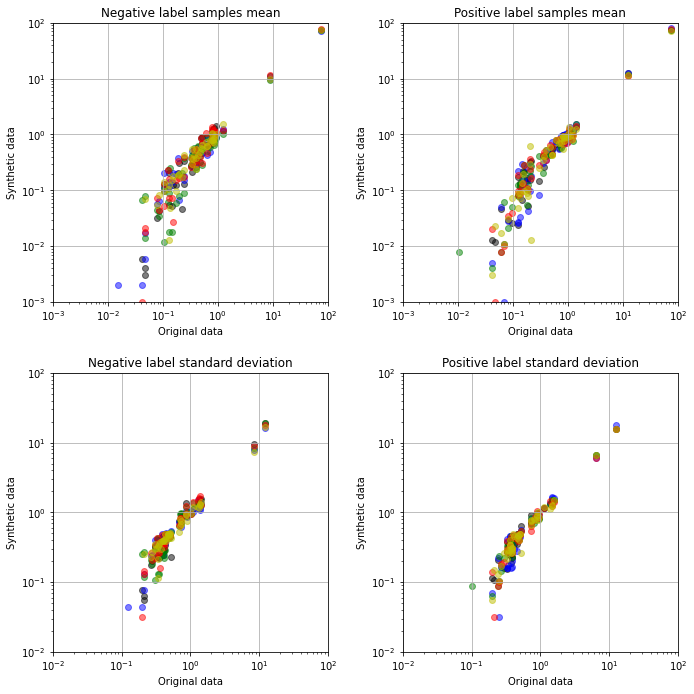

In [23]:
colours = ['k', 'b', 'g', 'r', 'y', 'c', 'm']
fig = plt.figure(figsize=(10,10))

# Note: Set x and y limits to avoid plotting values that are very close to zero

# Negative mean
ax1 = fig.add_subplot(221)
for run in range(number_of_runs):
    x = descriptive_stats_all_runs[0]['Original neg_label mean'].copy()
    y = descriptive_stats_all_runs[run]['Synthetic neg_label mean'].copy()
    x.drop(labels ='label', inplace=True)
    y.drop(labels ='label', inplace=True)
    colour = colours[run % 7] # Cycle through 7 colours
    ax1.scatter(x,y, color=colour, alpha=0.5)
ax1.set_xlabel('Original data')
ax1.set_ylabel('Synthetic data')
ax1.set_xlim(1e-3, 1e2)
ax1.set_ylim(1e-3, 1e2)
ax1.set_title('Negative label samples mean')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid()

# Positive mean
ax2 = fig.add_subplot(222)
for run in range(number_of_runs):
    x = descriptive_stats_all_runs[0]['Original pos_label mean'].copy()
    y = descriptive_stats_all_runs[run]['Synthetic pos_label mean'].copy()
    x.drop(labels ='label', inplace=True)
    y.drop(labels ='label', inplace=True)
    colour = colours[run % 7] # Cycle through 7 colours
    ax2.scatter(x,y, color=colour, alpha=0.5)
ax2.set_xlabel('Original data')
ax2.set_ylabel('Synthetic data')
ax2.set_title('Positive label samples mean')
ax2.set_xlim(1e-3, 1e2)
ax2.set_ylim(1e-3, 1e2)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid()

# Negative standard deviation
ax3 = fig.add_subplot(223)
for run in range(number_of_runs):
    x = descriptive_stats_all_runs[0]['Original neg_label std'].copy()
    y = descriptive_stats_all_runs[run]['Synthetic neg_label std'].copy()
    x.drop(labels ='label', inplace=True)
    y.drop(labels ='label', inplace=True)
    colour = colours[run % 7] # Cycle through 7 colours
    ax3.scatter(x,y, color=colour, alpha=0.5)
ax3.set_xlabel('Original data')
ax3.set_ylabel('Synthetic data')
ax3.set_title('Negative label standard deviation')
ax3.set_xlim(1e-2, 1e2)
ax3.set_ylim(1e-2, 1e2)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.grid()

# Positive standard deviation
ax4 = fig.add_subplot(224)
for run in range(number_of_runs):
    x = descriptive_stats_all_runs[0]['Original pos_label std'].copy()
    y = descriptive_stats_all_runs[run]['Synthetic pos_label std'].copy()
    x.drop(labels ='label', inplace=True)
    y.drop(labels ='label', inplace=True)
    colour = colours[run % 7] # Cycle through 7 colours
    ax4.scatter(x,y, color=colour, alpha=0.5)
ax4.set_xlabel('Original data')
ax4.set_ylabel('Synthetic data')
ax4.set_title('Positive label standard deviation')
ax4.set_xlim(1e-2, 1e2)
ax4.set_ylim(1e-2, 1e2)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.grid()

plt.tight_layout(pad=2)
plt.savefig('Output/gan_correls.png', facecolor='w', dpi=300)
plt.show()

Calculate correlations between means and standard deviations for negative and positive classes.

In [24]:
correl_mean_neg = []
correl_std_neg = []
correl_mean_pos = []
correl_std_pos = []

for run in range(number_of_runs):
    # Get correlation of means
    x = descriptive_stats_all_runs[run]['Original neg_label mean']
    y = descriptive_stats_all_runs[run]['Synthetic neg_label mean']
    correl_mean_neg.append(np.corrcoef(x,y)[0,1])
    x = descriptive_stats_all_runs[run]['Original pos_label mean']
    y = descriptive_stats_all_runs[run]['Synthetic pos_label mean']
    correl_mean_pos.append(np.corrcoef(x,y)[0,1])
    
    # Get correlation of standard deviations
    x = descriptive_stats_all_runs[run]['Original neg_label std']
    y = descriptive_stats_all_runs[run]['Synthetic neg_label std']
    correl_std_neg.append(np.corrcoef(x,y)[0,1])
    x = descriptive_stats_all_runs[run]['Original pos_label std']
    y = descriptive_stats_all_runs[run]['Synthetic pos_label std']
    correl_std_pos.append(np.corrcoef(x,y)[0,1])

# Get correlation of means
mean_r_square_mean_neg = np.mean(np.square(correl_mean_neg))
mean_r_square_mean_pos = np.mean(np.square(correl_mean_pos))
sem_square_mean_neg = np.std(np.square(correl_mean_neg))/np.sqrt(number_of_runs)
sem_square_mean_pos = np.std(np.square(correl_mean_pos))/np.sqrt(number_of_runs)

print ('R-square of means (negative), mean (std): ', end='')
print (f'{mean_r_square_mean_neg:0.3f} ({sem_square_mean_neg:0.3f})')
print ('R-square of means (positive), mean (std): ', end='')
print (f'{mean_r_square_mean_pos:0.3f} ({sem_square_mean_pos:0.3f})')

# Get correlation of standard deviations
mean_r_square_sd_neg = np.mean(np.square(correl_std_neg))
mean_r_square_sd_pos = np.mean(np.square(correl_std_pos))
sem_square_sd_neg = np.std(np.square(correl_std_neg))/np.sqrt(number_of_runs)
sem_square_sd_pos = np.std(np.square(correl_std_pos))/np.sqrt(number_of_runs)

print ('R-square of standard deviations (negative), mean (sem): ', end='')
print (f'{mean_r_square_sd_neg:0.3f} ({sem_square_sd_neg:0.3f})')
print ('R-square of standard deviations (positive), mean (sem): ', end='')
print (f'{mean_r_square_sd_pos:0.3f} ({sem_square_sd_pos:0.3f})')

R-square of means (negative), mean (std): 0.999 (0.000)
R-square of means (positive), mean (std): 1.000 (0.000)
R-square of standard deviations (negative), mean (sem): 0.967 (0.004)
R-square of standard deviations (positive), mean (sem): 0.987 (0.003)


## Single run example

In [25]:
descriptive_stats_all_runs[0]

Original pos_label mean  \
Hosp_1                                                      0.203728   
Hosp_2                                                      0.122503   
Hosp_3                                                      0.182423   
Hosp_4                                                      0.137150   
Hosp_5                                                      0.067909   
Hosp_6                                                      0.123835   
Hosp_7                                                      0.162450   
Male                                                        0.515313   
Age                                                        73.303595   
Age_80                                                      0.346205   
Onset Time Known Type_BE                                    0.149134   
Onset Time Known Type_NK                                    0.010652   
Onset Time Known Type_P                                     0.840213   
# Comorbidities                                             1.053262   
2+ comorbidotes                                             0.298269   
Congestive HF                                               0.041278   
Hypertension                                                0.464714   
Atrial Fib                                                  0.186418   
Diabetes                                                    0.151798   
TIA                                                         0.209055   
Co-mordity                                                  0.676431   
Antiplatelet_0                                              0.097204   
Antiplatelet_1                                              0.079893   
Antiplatelet_NK                                             0.822903   
Anticoag before stroke_0                                    0.122503   
Anticoag before stroke_1                                    0.046605   
Anticoag before stroke_NK                                   0.830892   
Stroke severity group_1. No stroke symtpoms                 0.002663   
Stroke severity group_2. Minor                              0.061252   
Stroke severity group_3. Moderate                           0.619174   
Stroke severity group_4. Moderate to severe                 0.182423   
Stroke severity group_5. Severe                             0.134487   
Stroke Type_I                                               1.000000   
Stroke Type_PIH                                             0.000000   
S2RankinBeforeStroke                                        0.360852   
S2NihssArrival                                             12.515313   
S2NihssArrivalLocQuestions                                  0.850866   
S2NihssArrivalLocCommands                                   0.394141   
S2NihssArrivalBestGaze                                      0.521971   
S2NihssArrivalVisual                                        0.809587   
S2NihssArrivalFacialPalsy                                   1.407457   
S2NihssArrivalMotorArmLeft                                  1.215712   
S2NihssArrivalMotorArmRight                                 1.073236   
S2NihssArrivalMotorLegLeft                                  1.165113   
S2NihssArrivalMotorLegRight                                 0.977364   
S2NihssArrivalLimbAtaxia                                    0.214381   
S2NihssArrivalSensory                                       0.762983   
S2NihssArrivalBestLanguage                                  1.181092   
S2NihssArrivalDysarthria                                    0.902796   
S2NihssArrivalExtinctionInattention                         0.762983   
label                                                       1.000000   

                                             Synthetic pos_label mean  \
Hosp_1                                                          0.315   
Hosp_2                                                          0.000   
Hosp_3                                                          0.154   
Hosp_4  

## Correlation between features

Here we calculate a correlation matric between all features for original and synthetic data.

In [26]:
neg_correlation_original = []
neg_correlation_synthetic = []
pos_correlation_original = []
pos_correlation_synthetic = []

correl_coeff_neg = []
correl_coeff_pos= []

# Original data
mask = original_data['label'] == 0
neg_o = original_data[mask].copy()
neg_o.drop('label', axis=1, inplace=True)
neg_correlation_original = neg_o.corr().values.flatten()

mask = original_data['label'] == 1
pos_o = original_data[mask].copy()
pos_o.drop('label', axis=1, inplace=True)
pos_correlation_original = pos_o.corr().values.flatten()

# Synthetic data
for i in range (number_of_runs):
    data_s = synthetic_data[i]
    
    mask = data_s['label'] == 0
    neg_s = data_s[mask].copy()
    neg_s.drop('label', axis=1, inplace=True)
    corr_neg_s = neg_s.corr().values.flatten()
    neg_correlation_synthetic.append(corr_neg_s)
    
    mask = data_s['label'] == 1
    pos_s = data_s[mask].copy()
    pos_s.drop('label', axis=1, inplace=True)
    corr_pos_s = pos_s.corr().values.flatten()
    pos_correlation_synthetic.append(corr_pos_s)

    # Get correlation coefficients
    df = pd.DataFrame()
    df['original'] = neg_correlation_original
    df['synthetic'] = corr_neg_s    
    correl_coeff_neg.append(df.corr().loc['original']['synthetic'])    
    
    df = pd.DataFrame()
    df['original'] = pos_correlation_original
    df['synthetic'] = corr_pos_s
    correl_coeff_pos.append(df.corr().loc['original']['synthetic']) 

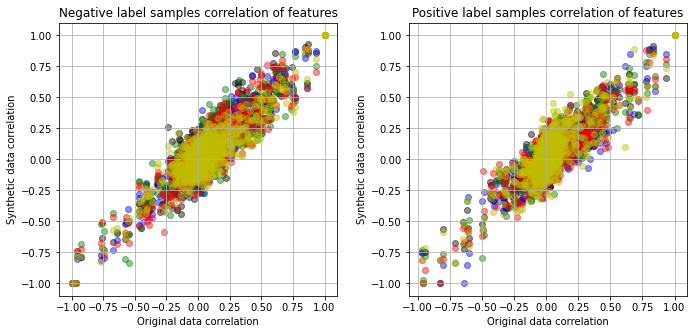

In [27]:
colours = ['k', 'b', 'g', 'r', 'y', 'c', 'm']
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
for run in range(number_of_runs):
    colour = colours[run % 7] # Cycle through 7 colours
    ax1.scatter(
        neg_correlation_original,
        neg_correlation_synthetic[run],
        color=colour,
        alpha=0.25)
ax1.grid()
ax1.set_xlabel('Original data correlation')
ax1.set_ylabel('Synthetic data correlation')
ax1.set_title('Negative label samples correlation of features')

ax2 = fig.add_subplot(122)
for run in range(number_of_runs):
    colour = colours[run % 7] # Cycle through 7 colours
    ax2.scatter(
        pos_correlation_original,
        pos_correlation_synthetic[run],
        color=colour,
        alpha=0.25)
ax2.grid()
ax2.set_xlabel('Original data correlation')
ax2.set_ylabel('Synthetic data correlation')
ax2.set_title('Positive label samples correlation of features')

plt.tight_layout(pad=2)
plt.savefig('Output/gan_cov.png', facecolor='w', dpi=300)
plt.show()

In [28]:
r_square_neg_mean = np.mean(np.square(correl_coeff_neg))
r_square_pos_mean = np.mean(np.square(correl_coeff_pos))
r_square_neg_sem = np.std(np.square(correl_coeff_neg))/np.sqrt(number_of_runs)
r_square_pos_sem = np.std(np.square(correl_coeff_pos))/np.sqrt(number_of_runs)

print ('Corrleation of correlations (negative), mean (sem): ', end='')
print (f'{r_square_neg_mean:0.3f} ({r_square_neg_sem:0.3f})')
print ('Corrleation of correlations (positive), mean (sem): ', end = '')
print (f'{r_square_pos_mean:0.3f} ({r_square_pos_sem:0.3f})')

Corrleation of correlations (negative), mean (sem): 0.833 (0.006)
Corrleation of correlations (positive), mean (sem): 0.828 (0.008)
